In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
from pathlib import Path
from typing import *
import torch
import torch.optim as optim
from transformers import *

class Configuracao(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [3]:
# !gsutil cp gs://dataset-uploader/bbc/bbc-text.csv .

In [4]:
torch.cuda.is_available()

True

In [5]:
config = Configuracao(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=6,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=128,
)

from pytorch_pretrained_bert import BertTokenizer

bert_token = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

class FastAiBertTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    def __call__(self, *args, **kwargs):
        return self
    def tokenizer(self, t:str) -> List[str]:
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_token, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_token.vocab.keys()))

df_train=pd.read_csv('train.csv')
df_train.columns

from sklearn.model_selection import train_test_split
train, val = train_test_split(df_train)

databunch = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=['toxic'],
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [6]:
databunch

TextClasDataBunch;

Train: LabelList (119678 items)
x: TextList
[CLS] why are you such an idiot ? ? [SEP],[CLS] fuck this mother ##fu ##cker asshole this asshole should not have his own page , nor should any other hi ##jack ##ers . giving them their own pages on wikipedia is g ##lor ##ifying their evil . i hope this mother ##fu ##cker rot ##s in hell . fuck mohammed at ##ta , sc ##um of the earth . [SEP],[CLS] yeah back ##fire is a very good word for it and i think you ' re on the money regarding imagine being pi ##mp ##ed . i ' m having a blast watching this un ##fold . [SEP],[CLS] i know that madonna ##tri ##be is a fans ##ite . nonetheless , almost all of their exclusive ##s have later been confirmed by official sources , such as the full set ##lists of madonna ' s two latest tours and titles of 5 songs off madonna ' s hard candy album . as of now , their news item on the track ##list ##ing is access ##able from their front page , as a top news story . however , as i ' ve already co

In [7]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

modelo = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

learn_data = Learner(
    databunch, modelo,
    metrics=[accuracy]
)

#learn_data.callbacks.append(ShowGraph(learner))



In [8]:
learn_data.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.10E-03


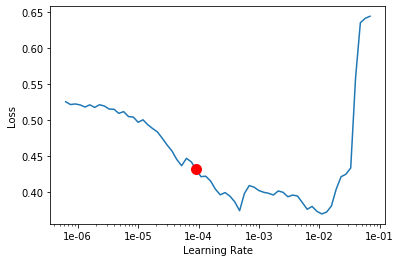

In [9]:
learn_data.recorder.plot(suggestion=True)

In [10]:
learn_data.fit_one_cycle(1, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.072850,0.079919,0.969168,11:40


In [11]:
learn_data.unfreeze()
learn_data.fit_one_cycle(3, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.071179,0.084944,0.967538,10:55
1,0.051193,0.103908,0.967689,13:03
2,0.021878,0.134671,0.967237,11:52


In [12]:
preds, targets = learn_data.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,35568,768
1,539,3018


In [13]:
data_lm = TextLMDataBunch.from_csv('/home/rubensvectomobile_gmail_com/', 'bbc-text.csv', min_freq=1)


In [14]:
data_lm.show_batch()

idx,text
0,the minimum wage was introduced in 1999 . businesses wanted it frozen warning more rises could damage competitiveness but the unions want a £ 6 rate . a further increase in the adult rate to £ 5.35 an hour is provisionally scheduled for october 2006 . according to the commission many businesses had found the last two significant increases in the minimum wage challenging . we have therefore recommended only
1,and the department for education and skills are running the programme . pupils will stand as party candidates speech writers and canvassers . michael raftery project manager at the hansard society said : the y vote mock elections for schools mirror the excitement and buzz of a real election raising awareness of citizenship and the benefits of active democracy . the mock votes will take place around 5 may widely
2,17-year - old andrew murray and david sherwood in the doubles rubber . bogdanovic and murray both pulled out of tournaments last week through injury but are expected to be fit . jamie delgado and lee childs have been called into the squad in tel aviv as designated hitters for team practice but bates has no plans to call either of them into his squad at present . the unheralded
3,said the budget was a wasted opportunity for environmental protection adding : brown obviously has an eye on the coming election and has taken his eye off the needs of the planet . xxbos stock market eyes japan recovery japanese shares have ended the year at their highest level since 13 july amidst hopes of an economic recovery during 2005 . the nikkei index of leading shares gained 7.6 %
4,media player and instant messaging . four other important fixes were also released . these were considered to be less critical however . if not updated either automatically or manually pc users running the programs could be vulnerable to viruses or other malicious attacks designed to exploit the holes . many of the flaws could be used by virus writers to take over computers remotely install programs change and delete


In [15]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [16]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(27744, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(27744, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=27744, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


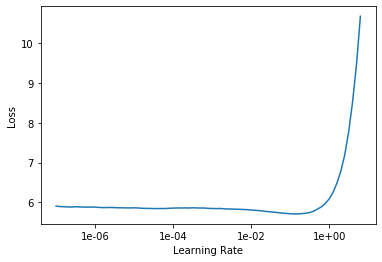

In [17]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,5.031863,4.565862,0.250085,00:15


In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,4.516709,4.425093,0.261166,00:18
1,4.286195,4.338158,0.268442,00:18
2,4.093995,4.322690,0.270057,00:18


In [20]:
learn.save_encoder('ft_enc_balanced')

In [21]:
data_clas = TextClasDataBunch.from_csv('/home/rubensvectomobile_gmail_com/', 'bbc-text.csv',vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save('train_ulmfit_balanced_TextClas')

In [22]:
data_clas.show_batch()

text,target
xxbos terror powers expose tyranny the lord chancellor has defended government plans to introduce control orders to keep foreign and british terrorist suspects under house arrest where there isn t enough evidence to put them on trial . lord falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties . but,politics
xxbos scissor sisters triumph at brits us band scissor sisters led the winners at the uk music industry s brit awards walking off with three prizes . the flamboyant act scored a hat - trick in the international categories winning the best group best album and best newcomer awards . glasgow group franz ferdinand won two prizes as did keane and joss stone who was voted best urban act by,entertainment
xxbos minimum wage increased to £ 5.05 the minimum wage will rise in october benefiting more than 1 m people the government has announced . adults must be paid at least £ 5.05 an hour up from £ 4.85 while 18 to 21 year olds will be paid £ 4.25 . the recommendations came from the low pay commission which said the number of jobs had continued to grow since,politics
xxbos brits debate over urban music joss stone a 17-year - old soul singer from devon beat dizzee rascal jamelia lemar and the streets to win best british urban act at the brit awards . her victory has reignited the debate about what urban music is . i m not really comfortable with the word urban . it s a word that s been manufactured in this country and america,entertainment
xxbos all black magic : new zealand rugby playing colours : all black the haka and more ! the all blacks charles john munro discovered rugby at london s christ college and on his return to nelson he staged new zealand s first game . nelson town met nelson college on 14 may 1870 the town triumphing by two goals to nil instigating a game that would become a national,sport


In [23]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc_balanced')
learn.freeze()

In [24]:
learn.metrics = [accuracy, FBeta('macro')]

In [25]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.00E-01


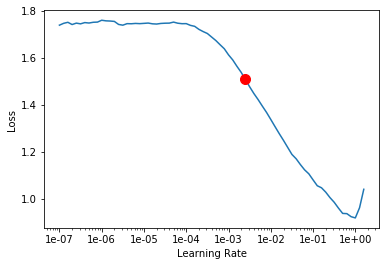

In [26]:
learn.recorder.plot(suggestion=True)

In [27]:
min_grad_lr = learn.recorder.min_grad_lr

In [28]:
learn.fit_one_cycle(cyc_len=1, max_lr=min_grad_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.424459,0.148500,0.973094,0.972047,00:14


In [29]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.253420,0.101894,0.968610,0.966273,00:20


In [30]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.206390,0.130862,0.948430,0.944258,00:22
1,0.214947,0.157496,0.948430,0.949081,00:24
2,0.191354,0.097212,0.961883,0.960544,00:21
3,0.126706,0.128991,0.961883,0.960982,00:22
4,0.106320,0.106188,0.970852,0.969827,00:22
5,0.076258,0.119914,0.970852,0.971086,00:24
6,0.060115,0.108603,0.973094,0.972529,00:23
7,0.037661,0.113315,0.977578,0.977161,00:24


In [31]:
learn.save("trained_ulmfit")

In [32]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)

In [33]:
learn.load('trained_ulmfit')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1779 items)
x: TextList
xxbos gadget growth fuels eco concerns technology firms and gadget lovers are being urged to think more about the environment when buying and disposing of the latest hi - tech products . at the consumer electronics show in las vegas earlier this month several hi - tech firms were recognised for their strategies to help the environment . ebay also announced the rethink project bringing together intel apple and ibm among others to promote recycling . the us consumer electronics market is set to grow by over 11 % in 2005 . but more awareness is needed about how and where old gadgets can be recycled as well as how to be more energy efficient said the us environmental protection agency ( epa ) . of particular growing concern is how much energy it takes to recharge portable devices one of the fastest growing markets in technology . the consumer electronics association ( cea ) has predicted that shipments of consume

In [34]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4
row_0,,,,,
0,101,1,0,1,1
1,1,73,0,0,1
2,2,0,93,0,1
3,0,0,0,95,1
4,0,0,1,0,74
